In [1]:
"""
Created By Kevin Du for OSGC Scholarship Program. Credits to "Neural network powered COVID-19 spread forecasting model"\
by Michał Wieczorek, Jakub Siłka, Marcin Woźniak for architecture and data processing.

https://doi.org/10.1016/j.chaos.2020.110203

~~notes notes notes
TODO: finish reading this paper https://osf.io/preprints/socarxiv/rn9xk
Second Draft: implementation of policy data
Purpose:
Intended result:
Notes: 
    Normalizing by the maximum infection rate hides a lot of the explainability of the model. The maximum infection rate
    of a state heavily depends on the population density, conformity to mask mandates, infection policies, etc. which are now
    potentially hidden due to the normalization
    
    Accuracy is heavily dependent on how many total points taken - having data from different strains to predict the next
    infection rate increases the loss dramatically
"""

'\nCreated By Kevin Du for OSGC Scholarship Program. Credits to "Neural network powered COVID-19 spread forecasting model"by Michał Wieczorek, Jakub Siłka, Marcin Woźniak for architecture and data processing.\n\nhttps://doi.org/10.1016/j.chaos.2020.110203\n\n~~notes notes notes\nTODO: finish reading this paper https://osf.io/preprints/socarxiv/rn9xk\nSecond Draft: implementation of policy data\nPurpose:\nIntended result:\nNotes: \n    Normalizing by the maximum infection rate hides a lot of the explainability of the model. The maximum infection rate\n    of a state heavily depends on the population density, conformity to mask mandates, infection policies, etc. which are now\n    potentially hidden due to the normalization\n    \n    Accuracy is heavily dependent on how many total points taken - having data from different strains to predict the next\n    infection rate increases the loss dramatically\n'

In [2]:
import tensorflow as tf
from keras import layers
import math
import numpy as np
import pandas as pd
import csv
import pprint
import matplotlib.pyplot as plt
from functools import partial

In [3]:
##---------Data Hyperparameters-------------
#number of days in a grouping
time_step = 14

In [4]:
##---------Parameters of infection rate data----------
#start date of infection data is 4/12/2020
#end date of infection data is 1/7/2022
##---------Import of infection rate data----------------

#State/territory list (sorted alphabetically)
statelist= [[] for _ in range(58)]

#Total number of regions we are tracking
state_list_size = len(statelist)

#List of non-State and non-DC rows (start counting at 1)
staterowlist=[4,11,15,16,41,46,54]

#folderpath to 
folderpath = r"C:\Kevin\Applications\OSGC Undergraduate scholarship\COVID-19\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports_us" + "\\"

with open(r"C:\Kevin\Applications\OSGC Undergraduate scholarship\Date List.csv") as file:
    reader = csv.reader(file)
    datelist = list(reader)
datelist=datelist[0]

#total count of days of data
count=len(datelist)

for i in range(0, count):
    splitdate = datelist[i].split("/")
    datelist[i] = splitdate[0] + "-" + splitdate[1] + "-20" + splitdate[2]

#could optimize by adding the 'columns' as a row, then flipping everything with numpy

#extract all the confirmed cases by date from all the data
for date in datelist:
    filepath = folderpath + date + ".csv"
    with open(filepath) as file:
        reader = csv.reader(file)
        data = list(reader)
    for i in range(58):
        statelist[i].append(data[i+1][5])
    
#Infection rates (Total cases) now stored in an array, with each row [first index] representing a state or region,
#and each column [second index] representing a date for the infection
    
    
#--------------Normalization of data------------   

#Make numpy recognize that data is numerical
statelist = np.array(statelist).astype(float)

#Normalize by the highest infection rate
#should maybe normalize by total population
maxstatelist = np.amax(statelist, axis=1)
statelist = statelist / maxstatelist[:,None]

#Infection rates now in terms of (cases/max) with max as the highest one day infection cases




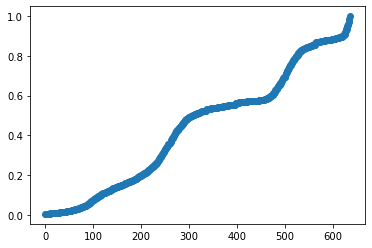

In [5]:
y=statelist[0].tolist()
plt.scatter(range(len(y)),y)

In [6]:
##--------------------Import of policy data-------------------
# retrieved from https://github.com/CoronaNetDataScience/corona_index

df = pd.read_csv (r'C:\Kevin\Applications\OSGC Undergraduate scholarship\corona_index\indices\all_indices.csv')
start_row = 502945
end_row = 505854
num_types = 6
#start date is 1/1/2020
#end date is 4/29/2021
stacked_policy = []
for i in range(int((end_row-start_row+1)/6)):
    date_start_row = start_row + num_types*i
    info = df['med_est'].iloc[date_start_row:date_start_row+num_types].to_list()
    stacked_policy.append(info)

#--------------Normalization of data------------   

#Make numpy recognize that data is numerical
policylist = np.array(stacked_policy).astype(float).T

#print(policylist)

#Normalize by the highest infection rate
#should maybe normalize by total population
maxpolicylist = np.amax(policylist, axis=1)
stacked_policy = policylist / maxpolicylist[:,None]

#print(stacked_policy)
#Infection rates now in terms of (cases/max) with max as the highest one day infection cases



In [7]:
##---------Training Hyperparameters-----------------------------
test_size = 39


##---------Imposed Parameters of Infection rate data----------
#start date of infection data is 4/12/2020
#end date of infection data is 1/7/2022 but policy data only goes to 4/29/2021
start_date = 0
end_date = 383
#end date of total data set [policy data only goes to a certain point]
#last number of days to use as test data
test_date_size = 30
#---------------Formatting of data---------------

#Start date of collated data set is 4/12/2020
#End date of collated data set is 4/29/2021
#Since we are inputting 14 days of infection information initially, ytrain will start on 4/26/2020

#grouping of data
gstatelist=[]

# group data into a list of first by start date, then by state. 
# Ex. The first 58 column arrays are the infection data for the first day of the 58 regions, in order
for i in range(time_step, end_date): # represents the date before prediction
    for j in range(state_list_size):
        gstatelist.append(statelist[j,(i-time_step):i].tolist()+stacked_policy[:,102+i].tolist())

xtrain_set=gstatelist[start_date*state_list_size:-test_size*state_list_size]
xvalidation_set=gstatelist[-test_size*state_list_size:]

ytrain_set=statelist[:,start_date+14:end_date-test_size].flatten('F').tolist()
yvalidation_set=statelist[:,end_date-test_size:end_date].flatten('F').tolist()

#Test print lines to be removed when finished with first draft
print('shape of gstatelist is '+ str(len(gstatelist)) +', '+str(len(gstatelist[0])))
print('length of xtrain is '+ str(len(xtrain_set)))
print('length of ytrain is '+str(len(ytrain_set)))
print('length of xval is '+ str(len(xvalidation_set)))
print('length of yval is '+ str(len(yvalidation_set)))

print('first xtrain looks like: ' + str(xtrain_set[0]))
print('first ytrain looks like: ' + str(ytrain_set[0]))

print()

#Infection rates (input set) are now in sets of 14 days, with the last three months of data reserved for validation 
#(testing set will come from most recent data not included)
#

shape of gstatelist is 21402, 20
length of xtrain is 19140
length of ytrain is 19140
length of xval is 2262
length of yval is 2262
first xtrain looks like: [0.0038283736041626647, 0.00404030702157336, 0.004218832215549858, 0.004496538072846631, 0.004661491176052986, 0.004757539818426306, 0.004998705431341925, 0.005197066757982477, 0.005390208049711437, 0.005641813732450243, 0.005942487743358028, 0.006158597188697998, 0.006360090536285507, 0.006550099807067509, 0.9454689909198672, 0.5067313170828072, 0.997963110441521, 0.40208156584594623, 0.9640427023713355, 0.9000983213111774]
first ytrain looks like: 0.006759945210513568



In [8]:
#hyperparameters
#input_shape=(14,)
#neuron



model = tf.keras.models.Sequential()
model.add(layers.Dense(units = 256, activation = 'tanh', input_shape = (20,)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(units = 96, activation = 'tanh'))
model.add(layers.Dropout(.2))
model.add(layers.Dense(units = 48, activation = 'tanh'))
model.add(layers.Dense(units = 28, activation = 'tanh'))
model.add(layers.Dense(units = 48, activation = 'tanh'))
model.add(layers.Dense(units = 12, activation = 'tanh'))
model.add(layers.Dense(units = 6, activation = 'tanh'))
model.add(layers.Dense(units = 1, activation = 'relu'))
model.compile(optimizer = 'Nadam', loss = 'mean_squared_error')




In [9]:
# ANN with policy data fit
model.fit(xtrain_set, ytrain_set, epochs =10)
test_loss = model.evaluate(xvalidation_set, yvalidation_set)
print(test_loss)

Epoch 1/10
599/599 [==============================] - 1s 997us/step - loss: 0.0016
Epoch 2/10
599/599 [==============================] - 1s 940us/step - loss: 3.9971e-04
Epoch 3/10
599/599 [==============================] - 1s 937us/step - loss: 2.6341e-04
Epoch 4/10
599/599 [==============================] - 1s 932us/step - loss: 2.4232e-04
Epoch 5/10
599/599 [==============================] - 1s 947us/step - loss: 2.0316e-04
Epoch 6/10
599/599 [==============================] - 1s 933us/step - loss: 1.8213e-04
Epoch 7/10
599/599 [==============================] - 1s 972us/step - loss: 1.4509e-04
Epoch 8/10
599/599 [==============================] - 1s 933us/step - loss: 1.4208e-04
Epoch 9/10
599/599 [==============================] - 1s 935us/step - loss: 1.3959e-04
Epoch 10/10
71/71 [==============================] - 0s 472us/step - loss: 4.6880e-04
0.0004687993205152452


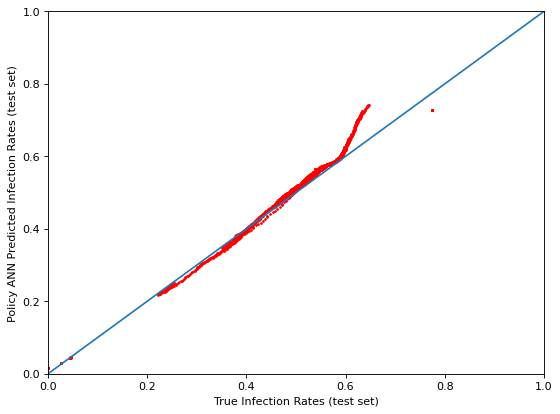

In [25]:
plt.figure(figsize=(8, 6), dpi=80)
predictions = model.predict(xvalidation_set)
plt.scatter(yvalidation_set,predictions, color='r', s=2)
plt.xlabel('True Infection Rates (test set)')
plt.ylabel('Policy ANN Predicted Infection Rates (test set)')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [11]:
print(predictions)

[[0.01787658]
 [0.01572715]
 [0.        ]
 ...
 [0.38938415]
 [0.5492099 ]
 [0.4782208 ]]


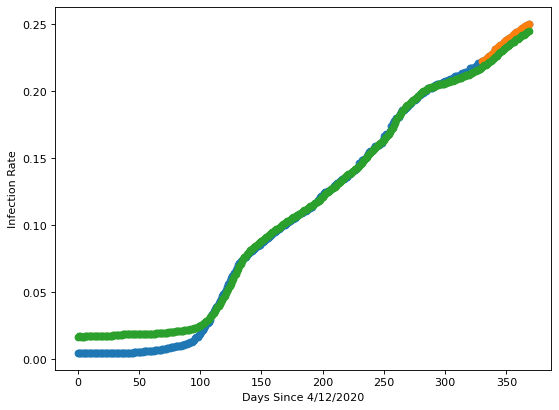

In [16]:

plt.figure(figsize=(8, 6), dpi=80)
xvalues = xtrain_set+xvalidation_set
yvalues = ytrain_set+yvalidation_set
index =list(range(int(len(xvalues)/state_list_size)))

territory =15
xstate=[]
ystate=[]
plt.xlabel('Days Since 4/12/2020')
plt.ylabel('Infection Rate')
for i in range(int(len(xvalues)/state_list_size)):
    xstate.append(xvalues[territory+i*state_list_size])
    ystate.append(yvalues[territory+i*state_list_size])

plt.scatter(index, ystate)
plt.scatter(index[-test_size:], ystate[-test_size:])

predictions = model.predict(xstate)
plt.scatter(index, predictions)